In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dotenv
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from mpl_toolkits.mplot3d import Axes3D
from lifetimes import BetaGeoFitter
from datetime import datetime

In [2]:
# Nome do arquivo com timestamp para evitar sobrescrever arquivos anteriores
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

try:
    # Conectar ao PostgreSQL
    print("Conectando ao banco de dados PostgreSQL...")
    conn = psycopg2.connect(
        host= os.getenv("hostAWS"),
        database="add",
        user= os.getenv("userADD"),
        password= os.getenv("addPass")
    )
    
    print("Conexão estabelecida com sucesso!")
    
    ########################################################
    # consulta da tabela vendas
    ########################################################
    
    print("Consultando a tabela vendas...")
    query = "SELECT * FROM vendas"
    
    # Carregar os dados diretamente em um DataFrame do pandas
    df_vendas = pd.read_sql_query(query, conn)
    
    # Informações sobre os dados
    num_registros = len(df_vendas)
    num_colunas = len(df_vendas.columns)
    
    print(f"Dados obtidos com sucesso! {num_registros} registros e {num_colunas} colunas.")
    print(f"Colunas disponíveis: {', '.join(df_vendas.columns)}")
    
    # Exibir uma amostra dos dados
    print("\nPrimeiros 5 registros para verificação:")
    print(df_vendas.head())
    
    # Exportar para Excel
    #df_vendas.to_excel("df_vendas.xlsx", index=False)

    # Fechar conexão
    conn.close()
    print("\nConexão com o banco de dados fechada.")

except Exception as e:
    print(f"Erro: {e}")
    print("\nVerifique se:")
    print("1. O PostgreSQL está rodando")
    print("2. O banco de dados 'add' existe")
    print("3. As credenciais de conexão estão corretas")

Conectando ao banco de dados PostgreSQL...
Conexão estabelecida com sucesso!
Consultando a tabela vendas...
Dados obtidos com sucesso! 21143 registros e 8 colunas.
Colunas disponíveis: id_venda, id_cliente, data_emissao, data_faturamento, total_venda, vendedor, status, tipo_pagamento

Primeiros 5 registros para verificação:
  id_venda  id_cliente data_emissao data_faturamento  total_venda  \
0   501883         650   2021-12-30       2022-01-04      1194.64   
1   501884         650   2021-12-30       2022-01-04      2025.68   
2   501885         650   2021-12-30       2022-01-04       205.54   
3   501965        1085   2021-12-30       2022-01-03      1185.00   
4   501966        1085   2021-12-30       2022-01-03       894.10   

        vendedor       status tipo_pagamento  
0  MARIA EDUARDA  Pedido/Pago         Boleto  
1  MARIA EDUARDA  Pedido/Pago         Boleto  
2  MARIA EDUARDA  Pedido/Pago         Boleto  
3  MARIA EDUARDA  Pedido/Pago         Boleto  
4  MARIA EDUARDA  Pedido

/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_89822/3561665399.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vendas = pd.read_sql_query(query, conn)


In [3]:
df_vendas['data_emissao'] = pd.to_datetime(df_vendas['data_emissao'])
# Filtrando todos os status que começam com "Pedido"
df_vendas = df_vendas[df_vendas['status'].str.startswith('Pedido')]
pedido_status = df_vendas[df_vendas['status'].str.startswith('Pedido')]['status'].unique()
print(pedido_status)

['Pedido/Pago' 'Pedido/Concluído' 'Pedido' 'Pedido/Pendente'
 'Pedido/Entregue' 'Pedido/Faturado']


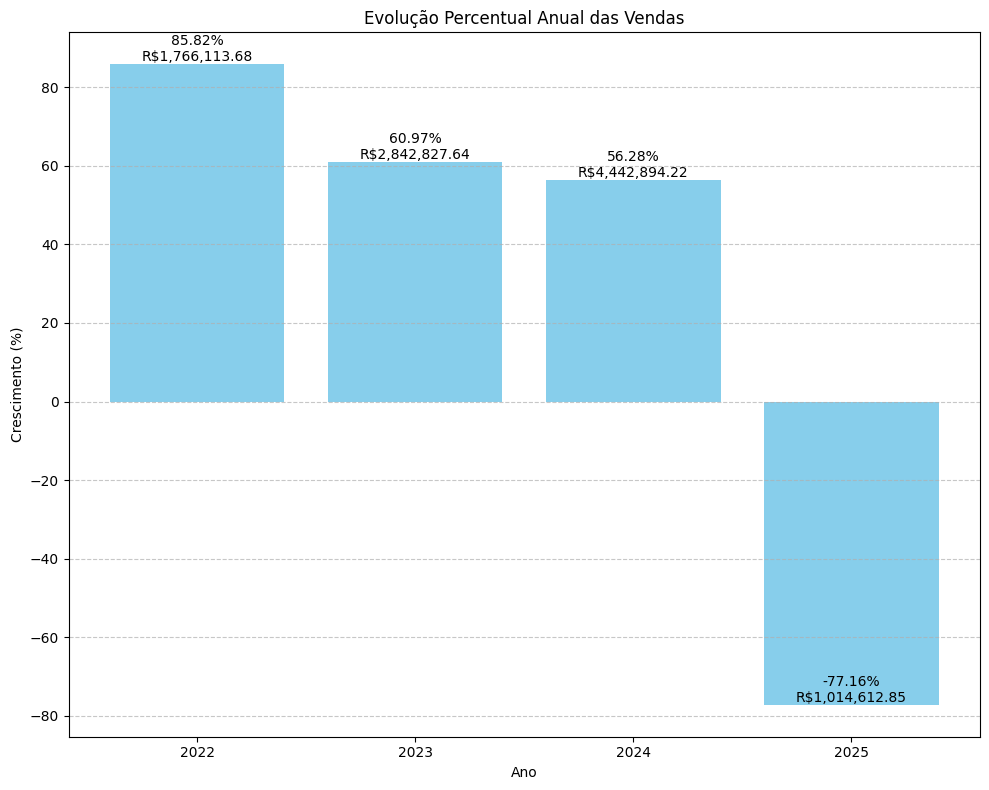

In [4]:
df_vendas['total_venda'] = pd.to_numeric(df_vendas['total_venda'], errors='coerce')

# Criar a coluna Ano
df_vendas['Ano'] = df_vendas['data_emissao'].dt.year

# Agregar os dados por Ano, somando o total de vendas
df_anual = df_vendas.groupby('Ano')['total_venda'].sum().reset_index()

# Calcular a evolução percentual anual (variação de um ano para o outro)
df_anual['Evolucao (%)'] = df_anual['total_venda'].pct_change() * 100

# Renomear a coluna total_venda para total_item para compatibilidade com o dashboard
df_anual.rename(columns={'total_venda': 'total_item'}, inplace=True)

# Exportar os dados para um arquivo Excel
df_anual.to_excel('faturamento_anual.xlsx', index=False)

# Plotar o gráfico de evolução percentual anual com labels
plt.figure(figsize=(10,8))
bars = plt.bar(df_anual['Ano'].astype(str), df_anual['Evolucao (%)'], color='skyblue')
plt.title('Evolução Percentual Anual das Vendas')
plt.xlabel('Ano')
plt.ylabel('Crescimento (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar os labels com a porcentagem e o valor faturado em cada barra
for bar, perc, tot in zip(bars, df_anual['Evolucao (%)'], df_anual['total_item']):
    height = bar.get_height()
    # Cria uma label com duas linhas: a primeira para a porcentagem e a segunda para o faturamento
    label = f'{perc:.2f}%\nR${tot:,.2f}'
    plt.text(bar.get_x() + bar.get_width()/2, height, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()

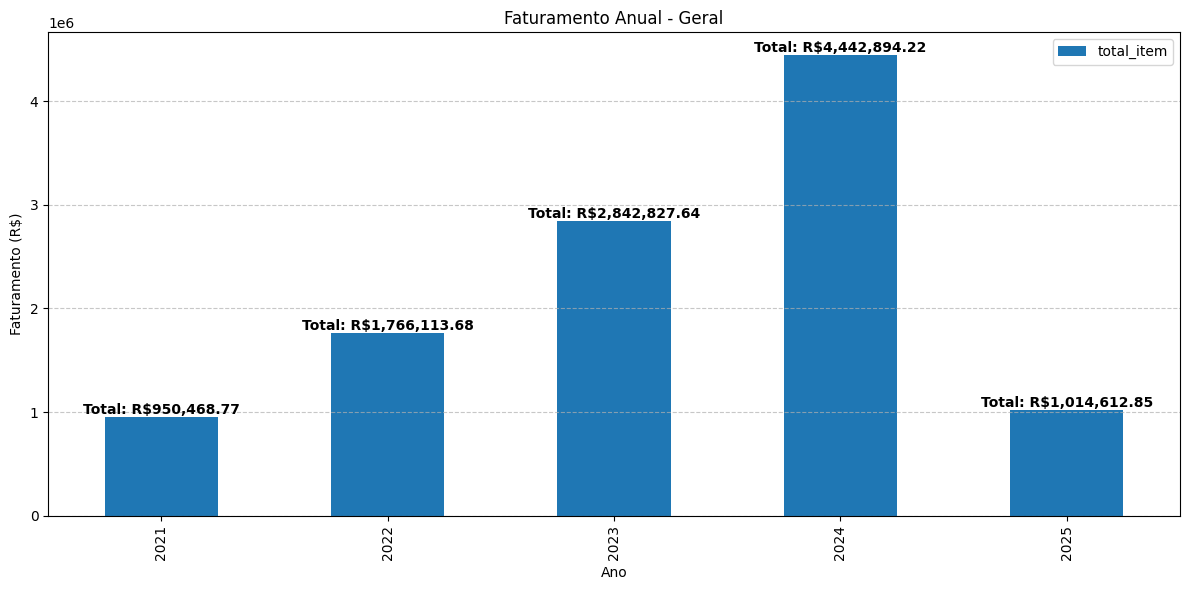

In [5]:
# --- Gráfico Geral: Faturamento Anual ---

# Agregar os dados por Ano (sem considerar grupo_cliente)
df_ano = df_vendas.groupby('Ano')['total_venda'].sum().reset_index()
df_ano.columns = ['Ano', 'total_item']

# Exportar os dados para um arquivo Excel
df_ano.to_excel('faturamento_anual_geral.xlsx', index=False)

# Plotar o gráfico de barras
ax = df_ano.plot(x='Ano', y='total_item', kind='bar', figsize=(12,6), color='#1f77b4')
plt.title('Faturamento Anual - Geral')
plt.xlabel('Ano')
plt.ylabel('Faturamento (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adicionar label com o valor total no topo de cada barra
for i, row in enumerate(df_ano.itertuples()):
    ax.text(i, row.total_item, f'Total: R${row.total_item:,.2f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

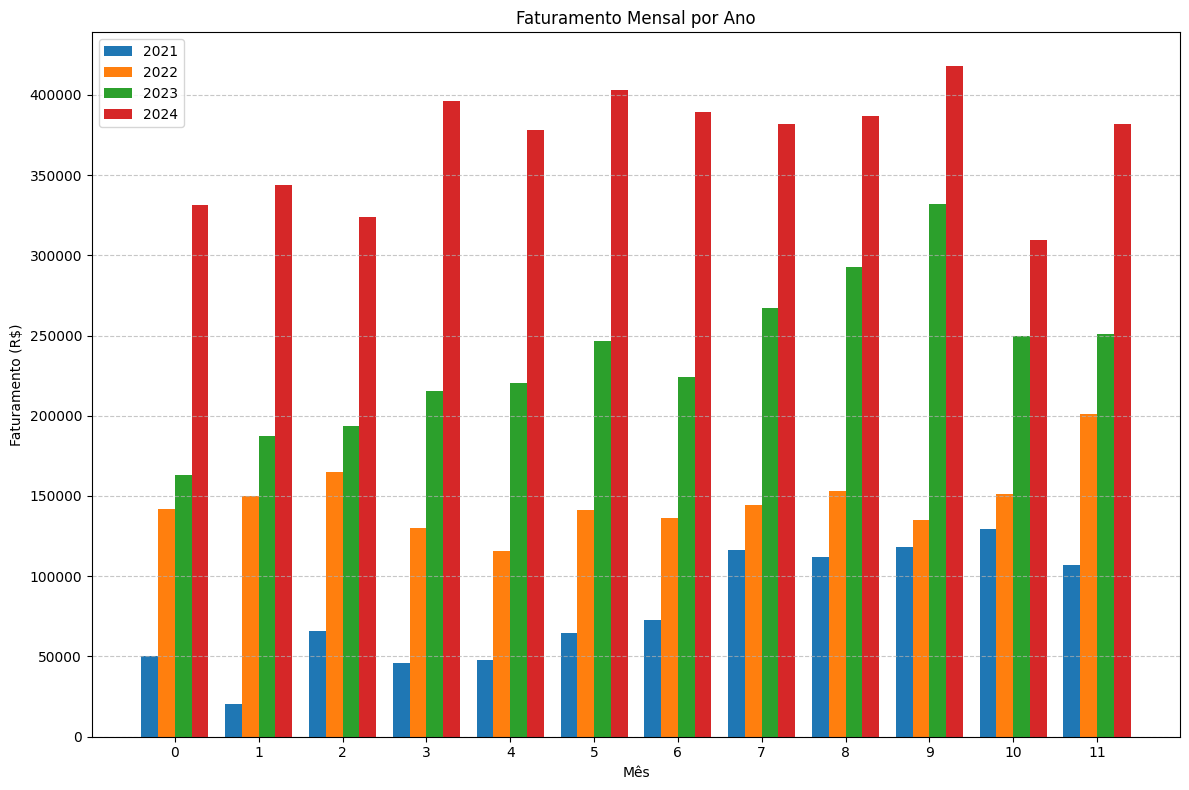

In [6]:
df_vendas['Mês'] = df_vendas['data_emissao'].dt.month

# Agrupar por Ano e Mês somando o total_item
df_pivot = df_vendas.groupby(['Ano', 'Mês'])['total_venda'].sum().reset_index()
df_pivot = df_pivot.pivot(index='Mês', columns='Ano', values='total_venda')
df_pivot.reset_index(inplace=True)
df_pivot.to_excel('faturamento_mensal.xlsx', index=False)

anos = [2021, 2022, 2023, 2024]  # anos de interesse
fig, ax = plt.subplots(figsize=(12, 8))

# Configurar a largura das barras e a posição no eixo x
width = 0.2  
x = np.arange(len(df_pivot.index))  # índices para os meses
num_anos = len(anos)

# Plotar as barras para cada ano com deslocamentos para que fiquem lado a lado
for i, ano in enumerate(anos):
    # Caso algum ano não tenha dados para determinados meses, use 0 como valor padrão
    valores = df_pivot[ano].fillna(0)
    ax.bar(x + i * width, valores, width=width, label=str(ano))

# Configurar os rótulos do eixo x para que fiquem centralizados
ax.set_xticks(x + width * (num_anos - 1) / 2)
ax.set_xticklabels(df_pivot.index)
ax.set_title('Faturamento Mensal por Ano')
ax.set_xlabel('Mês')
ax.set_ylabel('Faturamento (R$)')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()